## Curve fiting of proteins by dose 

In order to start plotting the curves, we made some modifications to the dose values:  

- we transformed the doses to a logarithmic scale: `dose_log <- log10(dose)`  
- we set the dose spacing to 1: `dose_spacing = 1`  
- we shifted the dose values to ensure all were positive:  
  `dose_shift = abs(min(dose_log)) + dose_spacing`  
- finally, we applied the shift: `dose_log_shifted <- dose_log + dose_shift`  

We then used the **fastbmdR** package on our **norm_signal** data, after filtering out proteins that had 100% missing values.

In [4]:
#
library(ggplot2)

#install.packages("drc", dependencies = TRUE)

devtools::install_github("jessica-ewald/fastbmdR")


Using GitHub PAT from the git credential store.

Skipping install of 'fastbmdR' from a github remote, the SHA1 (b3681861) has not changed since last install.
  Use `force = TRUE` to force installation



In [5]:
library(fastbmdR)
library(dplyr)
library(knitr)

In [ ]:
#df <- read.csv("./outputs/norm_signal_filtered.csv", sep= ',')

In [29]:
## computing the BMD for the proteiomic data

df <- read.csv("../00.exploratory_analysis/outputs/df_CC_Proba.csv", sep = ",")

df <- df[df$Metadata_Categories != "JUMP Control", ]
df <- df[df$Metadata_Compound != "UNTREATED", ]


df <- df %>%
  rename(
    CC0 = Metadata_Count_Cells,
    RF0 = Probability
  )

models <- c("Exp2", "Exp3", "Exp4", "Exp5", "Poly2", "Lin", "Power", "Hill")

ncpus <- 1  

unique_compounds <- unique(df$Metadata_Compound)

feat_cols =colnames(df)[!grepl("Metadata", colnames(df))]
res = list()
gene_table <- list()

for (compound in unique_compounds) {
  
  compound_data <- df[df$Metadata_Compound %in% c(compound, "DMSO"), ]
  
  dose <- compound_data$Metadata_Concentration
  
  dose_log <- dose
  dose_log[dose_log > 0] <- log10(dose_log[dose_log > 0])
  
  rank_dose = unique(dose) %>% sort(. , decreasing = TRUE)
  dose_spacing = abs(log10(rank_dose[2]/rank_dose[1]))
  
  dose_shift = abs(min(dose_log)) + dose_spacing
  
  dose_shifted = dose_log
  dose_shifted[dose_shifted != 0] = dose_shifted[dose_shifted != 0] + dose_shift
  
  
  if (length(unique(compound_data$Metadata_Concentration)) > 2) {  
    
    print(paste("Processing compound:", compound))  
    dose <- dose_shifted
    
    compound_mat <- compound_data[, feat_cols]  
    compound_mat = t(compound_mat)  
    
    min_val = abs(min(compound_mat, na.rm=TRUE))  
    add_min = min_val + 0.1 * min_val  
    mat_new = compound_mat + add_min  

    
    if (length(dose) == ncol(mat_new)) {  
      tryCatch({
 
        fit_obj <- PerformCurveFitting(data = mat_new, dose = dose, ncpus = ncpus, models = models)
        
        fit_obj <- FilterDRFit(fit_obj, lof.pval = 0.1, filt.var = "AIC.model")
        

        fit_obj <- PerformBMDCalc(fit_obj, ncpus = ncpus, num.sds = 2, bmr.method = "sample.mean", log10.dose = TRUE)
        

        bmd_res <- fit_obj$bmd_res
        bmd_pass <- bmd_res[bmd_res$all.pass, ]
        fit_obj$bmd_pass <- bmd_pass

        res[[compound]] = fit_obj
        
        gene_ids <- res[[compound]][["bmd_pass"]][["gene.id"]]
        bmd_values <- res[[compound]][["bmd_pass"]][["bmd"]]
        bmd_l <- res[[compound]][["bmd_pass"]][["bmdl"]]
        bmd_u <- res[[compound]][["bmd_pass"]][["bmdu"]]
        gene_table[[compound]] <- data.frame(
          gene_id = gene_ids,
          bmd_value = bmd_values,
          bmd_l = bmd_l,
          bmd_u = bmd_u
        )
        
          if (nrow(bmd_pass) > 0) {
          bmd_pass$compound_name <- compound
            if (!exists("all_bmd_pass")) {
              all_bmd_pass <- bmd_pass
            } else {
              all_bmd_pass <- rbind(all_bmd_pass, bmd_pass)
            }
        }
        
        #plot_bmd_curve("O00175", res$compound)
        
        #print(paste("Results for compound:", compound))
        #print(bmd_pass)
        
      }, error = function(e) {
        
        print(paste("Error with compound:", compound, "- ignoring this compound"))
      })
    }
  }  
}


[1] "Processing compound: Actinomycin D"
[1] "Processing compound: Bevirimat"
[1] "Processing compound: Ethoxyquin"
[1] "Processing compound: Amperozide"
[1] "Processing compound: IOPANOIC ACID"
[1] "Processing compound: Treprostinil"
[1] "Processing compound: MILTEFOSINE"
[1] "Processing compound: Lys05"
[1] "Processing compound: 5,8,11-Eicosatriynoic acid"
[1] "Processing compound: Cycloheximide"
[1] "Processing compound: CLIOQUINOL"
[1] "Processing compound: Berberine chloride"
[1] "Processing compound: Rifampicin"
[1] "Processing compound: Cucurbitacin I"
[1] "Processing compound: Triamcinolone acetonide"
[1] "Processing compound: Imiquimod"
[1] "Processing compound: MUPIROCIN"
[1] "Processing compound: Nedocromil (sodium salt)"
[1] "Processing compound: Staurosporine"
[1] "Processing compound: Cladribine"
[1] "Processing compound: 5,6-benzoflavone"
[1] "Processing compound: Natamycin"
[1] "Processing compound: FCCP"
[1] "Processing compound: PEMIROLAST POTASSIUM"
[1] "Processing c

In [32]:
print(head(all_bmd_pass))

  gene.id mod.name          b  c         d            e  f        SDres
1     CC0     Exp3 -0.2011014 NA 10.220468 4268.7085463 NA 5.614215e+02
2  O00175     Exp3 -0.1451800 NA  4.038302    0.1885055 NA 1.315806e-02
3  O00220     Exp3  0.1497130 NA  3.552933    0.1889675 NA 1.268147e-02
4  O00585     Exp3 -0.1507501 NA  6.664378    0.1838572 NA 9.734428e-03
5  O14625     Exp3 -0.1834194 NA 13.251002    0.1879903 NA 9.589763e-03
6  O14672     Exp3  0.1744042 NA 12.042006    0.1933486 NA 9.149119e-03
  AIC.model     lof.p     ctrl.mod    ctrl.mean adv.incr      bmd     bmdl
1   1337.85 0.4566987 2194.9168557 4319.4176657    FALSE 4.404246 4.359443
2   -495.88 0.9345332    0.1500227    0.1884040    FALSE 4.312967 4.201999
3   -502.23 0.2263699    0.2561455    0.1877780     TRUE 3.680899 3.557077
4   -547.72 0.1939868    0.1643244    0.1837944    FALSE 4.778108 4.702447
5   -550.29 0.1887892    0.1579528    0.1882981    FALSE 4.601864 4.564191
6   -558.38 0.4632513    0.2161105    0.193585

In [28]:
print(gene_table)

$`Actinomycin D`
     gene_id   bmd_value       bmd_l      bmd_u
1        CC0 4.404246079 4.359442550 4.44410263
2     O00175 4.312967300 4.201999272 4.41439711
3     O00220 3.680898887 3.557077006 3.79643960
4     O00585 4.778108303 4.702446664 4.84678291
5     O14625 4.601863813 4.564191404 4.63574223
6     O14672 4.701246380 4.656599622 4.74203529
7     O14836 4.074948402 3.995934114 4.14766327
8     O15467 4.054353764 4.007919236 4.09596897
9     O43508 4.737276987 4.525767493 4.93819662
10    O75144 4.415264340 4.338753990 4.48611211
11    O75509 1.126207414 0.958278967 1.32201693
12    O95760 4.586550953 4.513039000 4.65402787
13    P00533 3.636946997 3.473141566 3.79100180
14    P01031 4.423068762 4.367243077 4.47301314
15    P01137 2.588123809 2.310648386 2.86310610
16  P01137.1 4.582487545 4.475929577 4.68151079
17    P01138 4.394133228 4.348891248 4.43478845
18    P01579 4.069485997 3.931628634 4.19704819
19    P01583 3.558432983 3.429583142 3.68136140
20    P02775 3.50834626

In [27]:
## we can now create a table with the protein ids that has a response and their corresponding compound names
 


library(knitr)

gene_df <- do.call(rbind, lapply(names(gene_table), function(compound) {  
  gene_data <- gene_table[[compound]]  # Récupérer le data.frame
  
  if (!is.null(gene_data) && nrow(gene_data) > 0) {  
    return(data.frame(
      gene_id = gene_data$gene_id,
      bmd_value = gene_data$bmd_value,
      bmd_l = gene_data$bmd_l,
      bmd_u = gene_data$bmd_u,
      compound_name = compound,
      stringsAsFactors = FALSE
    ))
  } else {  
    return(NULL)  
  }  
}))


print(gene_df)


     gene_id   bmd_value       bmd_l      bmd_u
1        CC0 4.404246079 4.359442550 4.44410263
2     O00175 4.312967300 4.201999272 4.41439711
3     O00220 3.680898887 3.557077006 3.79643960
4     O00585 4.778108303 4.702446664 4.84678291
5     O14625 4.601863813 4.564191404 4.63574223
6     O14672 4.701246380 4.656599622 4.74203529
7     O14836 4.074948402 3.995934114 4.14766327
8     O15467 4.054353764 4.007919236 4.09596897
9     O43508 4.737276987 4.525767493 4.93819662
10    O75144 4.415264340 4.338753990 4.48611211
11    O75509 1.126207414 0.958278967 1.32201693
12    O95760 4.586550953 4.513039000 4.65402787
13    P00533 3.636946997 3.473141566 3.79100180
14    P01031 4.423068762 4.367243077 4.47301314
15    P01137 2.588123809 2.310648386 2.86310610
16  P01137.1 4.582487545 4.475929577 4.68151079
17    P01138 4.394133228 4.348891248 4.43478845
18    P01579 4.069485997 3.931628634 4.19704819
19    P01583 3.558432983 3.429583142 3.68136140
20    P02775 3.508346265 3.156862139 3.8

In [ ]:
## we calcule the actual concentration of the bmd value


gene_df$Concentration <- NA
for (i in 1:nrow(gene_df)) {
  compound <- gene_df$compound_name[i]
  bmd_value <- gene_df$bmd_value[i]

  compound_dt <- df[df$Metadata_Compound == compound, ]
  dose <- compound_dt$Metadata_Concentration
  dose_shift <- abs(min(log10(dose))) + 1
  recovered_concentration <- 10^(bmd_value - dose_shift)
  
  gene_df$Concentration[i] <- recovered_concentration
}

gene_df <- merge(gene_df, df[, c("Metadata_Compound", "Metadata_Categories")], 
                 by.x = "compound_name", by.y = "Metadata_Compound", 
                 all.x = TRUE)


kable(head(gene_df))


In [15]:
## calculating the bmd values at real concentration

gene_df$Concentration <- NA
gene_df$Concentration_L <- NA
gene_df$Concentration_U <- NA

for (i in 1:nrow(gene_df)) {
  compound <- gene_df$compound_name[i]
  bmd <- gene_df$bmd_value[i]
  bmdl <- gene_df$bmd_l[i]
  bmdu <- gene_df$bmd_u[i]

  compound_data <- df[df$Metadata_Compound == compound, ]
  dose <- compound_data$Metadata_Concentration

  dose_log <- dose
  dose_log[dose_log > 0] <- log10(dose_log[dose_log > 0])

  rank_dose <- unique(dose) %>% sort(decreasing = TRUE)
  dose_spacing <- abs(log10(rank_dose[2] / rank_dose[1]))
  
  dose_shift <- abs(min(dose_log)) + dose_spacing

  gene_df$Concentration[i] <- 10^(bmd - dose_shift)
  gene_df$Concentration_L[i] <- 10^(bmdl - dose_shift)
  gene_df$Concentration_U[i] <- 10^(bmdu - dose_shift)
}


In [16]:
kable(head(gene_df))




|compound_name    |gene_id | bmd_value|    bmd_l|    bmd_u| Concentration|Metadata_Categories | Concentration_L| Concentration_U|
|:----------------|:-------|---------:|--------:|--------:|-------------:|:-------------------|---------------:|---------------:|
|5,6-benzoflavone |P15692  |  2.578226| 2.127043| 3.282491|      1.893197|Positive Control    |       0.6699043|        9.582097|
|5,6-benzoflavone |P15692  |  2.578226| 2.127043| 3.282491|      1.893197|Positive Control    |       0.6699043|        9.582097|
|5,6-benzoflavone |P15692  |  2.578226| 2.127043| 3.282491|      1.893197|Positive Control    |       0.6699043|        9.582097|
|5,6-benzoflavone |P15692  |  2.578226| 2.127043| 3.282491|      1.893197|Positive Control    |       0.6699043|        9.582097|
|5,6-benzoflavone |P15692  |  2.578226| 2.127043| 3.282491|      1.893197|Positive Control    |       0.6699043|        9.582097|
|5,6-benzoflavone |P15692  |  2.578226| 2.127043| 3.282491|      1.893197|Positive Contr

In [24]:
# Compter la fréquence des protéines
protein_freq <- table(gene_df$gene_id)

# Trier par ordre décroissant
protein_freq_sorted <- sort(protein_freq, decreasing = TRUE)

# Afficher les plus fréquentes
head(protein_freq_sorted, 10)  # Top 10





Q14393 P09341 Q15113 Q16610 Q9BY76 Q9H2A7 P13500 P16035 P0DJI8 Q12805 
   330    290    268    268    266    266    248    248    246    246 

In [18]:
list_plot <- list()  

for (i in 1:nrow(gene_df)) {  
  tryCatch({
    gene_id <- gene_df$gene_id[i]
    compound <- gene_df$compound_name[i]
    
    temp <- plot_bmd_curve(gene_id, res[[compound]], return_type = "plot.data")
    
    temp$protein <- gene_id
    temp$compound <- compound
    temp$category <- gene_df$Metadata_Categories[i]
    temp$bmd <- gene_df$bmd_value[i]
    temp$bmd_l <- gene_df$bmd_l[i]
    temp$bmd_u <- gene_df$bmd_u[i]
    
    list_plot[[i]] <- temp
  }, error = function(e) {
    message(sprintf("Error for gene_id %s and compound %s : %s", gene_id, compound, e$message))
  })
}

final_df <- do.call(rbind, list_plot)

kable(head(final_df))



|  x| Observations|      f_x|protein |compound         |category         |      bmd|    bmd_l|    bmd_u|
|--:|------------:|--------:|:-------|:----------------|:----------------|--------:|--------:|--------:|
|  0|    0.3581009| 0.376542|P15692  |5,6-benzoflavone |Positive Control | 2.578226| 2.127043| 3.282491|
|  0|    0.4220800| 0.376542|P15692  |5,6-benzoflavone |Positive Control | 2.578226| 2.127043| 3.282491|
|  0|    0.3495371| 0.376542|P15692  |5,6-benzoflavone |Positive Control | 2.578226| 2.127043| 3.282491|
|  0|    0.4032859| 0.376542|P15692  |5,6-benzoflavone |Positive Control | 2.578226| 2.127043| 3.282491|
|  0|    0.3639491| 0.376542|P15692  |5,6-benzoflavone |Positive Control | 2.578226| 2.127043| 3.282491|
|  0|    0.3423675| 0.376542|P15692  |5,6-benzoflavone |Positive Control | 2.578226| 2.127043| 3.282491|

In [ ]:
## we now plot the bmd curves for each compound and protein and save them in a pdf file

library(ggplot2)
library(ggforce)


n_per_page <- 9  


final_df$compound_protein <- paste(final_df$compound, final_df$protein, sep = " - ")


plot_groups <- unique(final_df$compound_protein)
n_pages <- ceiling(length(plot_groups) / n_per_page)


pdf_file <- "./outputs/bmd_curves_new.pdf"
pdf(pdf_file, width = 15, height = 10)

for (i in 1:n_pages) {
  tryCatch({
    p <- ggplot(final_df, aes(x = x, y = Observations)) +
      geom_point(show.legend = FALSE) +
      geom_line(aes(y = f_x), show.legend = FALSE) +

      geom_vline(aes(xintercept = bmd), linetype = "solid", color = "red") +  
      geom_vline(aes(xintercept = bmd_l), linetype = "dashed", color = "red") + 
      geom_vline(aes(xintercept = bmd_u), linetype = "dashed", color = "red") +  
      facet_wrap_paginate(~ compound_protein, ncol = 3, nrow = 3, page = i, scales = "free_y") +
      
      labs(title = sprintf("BMD curves", i),
           x = "Concentration",
           y = "Observation") +
      theme_bw() +
      theme(strip.text = element_text(size = 8))
    
    print(p) 
  }, error = function(e) {
    message(sprintf("Error in the page %d : %s", i, e$message))
  })
}
dev.off()


# A tibble: 27 x 5
   compound_name       mean_concentration min_concentration nb_proteins category
   <chr>                            <dbl>             <dbl>       <int> <chr>   
 1 5,6-benzoflavone                  1.13           0.371             2 Positiv~
 2 5,8,11-Eicosatriyn~             154.            31.6              34 Positiv~
 3 Actinomycin D                   101.             0.00507         113 Positiv~
 4 Aminodarone Hydroc~              28.2           12.0              11 Positiv~
 5 Amperozide                      155.            31.6              46 Positiv~
 6 Berberine chloride               33.8            0.00991          26 Positiv~
 7 Bevirimat                       274.           219.                8 Negativ~
 8 CLIOQUINOL                      128.            31.1              12 Negativ~
 9 Calcipotriol (hydr~             151.            43.2              25 Negativ~
10 Cladribine                      182.             0.0634           10 Positiv~
# i 17 mo

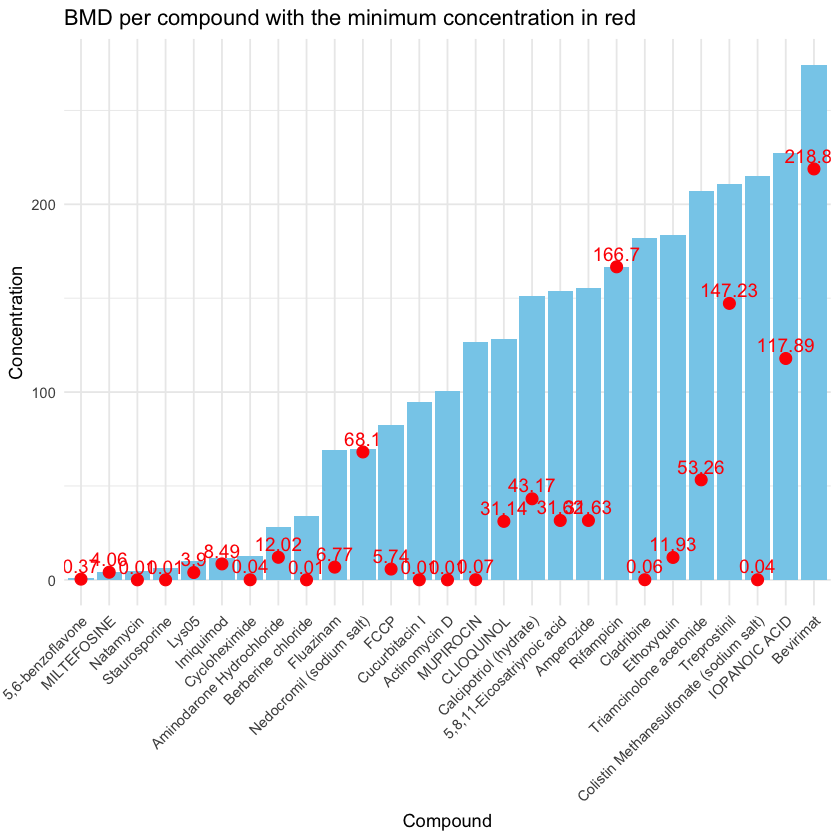

In [19]:
## Calculate the mean concentration for each compound


compound_summary <- gene_df %>%
  group_by(compound_name) %>%
  summarise(
    mean_concentration = mean(Concentration, na.rm = TRUE),  
    min_concentration = min(Concentration, na.rm = TRUE),   
    nb_proteins = n_distinct(gene_id),
    category = first(Metadata_Categories)              
  )


print(compound_summary)


p <- ggplot(compound_summary, aes(x = reorder(compound_name, mean_concentration), y = mean_concentration)) +
  geom_col(fill = "skyblue") + 
  geom_point(aes(y = min_concentration), color = "red", size = 3) +  
  geom_text(aes(y = min_concentration, label = round(min_concentration, 2)), 
            color = "red", vjust = -0.5, size = 4) + 
  #geom_text(aes(label = nb_proteins, y = mean_concentration + 5), size = 5, vjust = 0) +  
  labs(title = "BMD per compound with the minimum concentration in red",
       x = "Compound",
       y = "Concentration") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) 

print(p)

In [ ]:
#write.csv(compound_summary, "/Users/grigoryanmariam/newproject/2025_Grigoryan_Proteomics/01.dose_response/outputs/proteomic_bmd_dose_results.csv", row.names = FALSE)


In [23]:
print(compound_summary,  n = Inf)

# A tibble: 27 x 5
   compound_name       mean_concentration min_concentration nb_proteins category
   <chr>                            <dbl>             <dbl>       <int> <chr>   
 1 5,6-benzoflavone                  1.13           0.371             2 Positiv~
 2 5,8,11-Eicosatriyn~             154.            31.6              34 Positiv~
 3 Actinomycin D                   101.             0.00507         113 Positiv~
 4 Aminodarone Hydroc~              28.2           12.0              11 Positiv~
 5 Amperozide                      155.            31.6              46 Positiv~
 6 Berberine chloride               33.8            0.00991          26 Positiv~
 7 Bevirimat                       274.           219.                8 Negativ~
 8 CLIOQUINOL                      128.            31.1              12 Negativ~
 9 Calcipotriol (hydr~             151.            43.2              25 Negativ~
10 Cladribine                      182.             0.0634           10 Positiv~
11 Colist

## Cell Count From CP data

In [ ]:
library(arrow)
library(dplyr)

raw_data <- read_parquet("/Users/grigoryanmariam/newproject/2025_Grigoryan_Proteomics/00.exploratory_analysis/CP_data/raw.parquet")


df_pred <- read.csv("/Users/grigoryanmariam/newproject/2025_Grigoryan_Proteomics/00.exploratory_analysis/outputs/df_pred.csv", sep= ',')

raw_data <- raw_data %>% 
  filter(Metadata_BROAD_ID != "EMPTY")


raw_data <- raw_data %>%
  mutate(
    `Metadata_Compound Name` = ifelse(Metadata_BROAD_ID == "DMSO", "DMSO", `Metadata_Compound Name`),
    Metadata_Annotation = ifelse(Metadata_BROAD_ID == "DMSO", "DMSO", Metadata_Annotation)
  )

selected_data <- raw_data %>%
  select(`Metadata_Well`, `Metadata_Count_Cells`, `Metadata_Compound Name`)




In [85]:
write.csv(df, file = "./outputs/df_CC_Proba.csv", row.names = FALSE)

#/Users/grigoryanmariam/newproject/2025_Grigoryan_Proteomics/00.exploratory_analysis/outputs/bmd_curves.pdf

In [ ]:
# 
df_subset <- df[, c("Metadata_Compound", "Metadata_Concentration", "Metadata_Count_Cells")]

df_subset_clean <- df_subset[!is.na(df_subset$Metadata_Concentration) & 
                             !is.na(df_subset$Metadata_Count_Cells) & 
                             df_subset$Metadata_Compound != "UNTREATED", ]


df_subset_clean$compound_protein <- paste(df_subset_clean$Metadata_Compound, df_subset_clean$Metadata_Compound, sep = " - ")


df_subset_clean <- df_subset[!is.na(df_subset$Metadata_Concentration) & 
                             !is.na(df_subset$Metadata_Count_Cells) & 
                             df_subset$Metadata_Compound != "UNTREATED", ]


df_subset_clean$compound_protein <- paste(df_subset_clean$Metadata_Compound, df_subset_clean$Metadata_Compound, sep = " - ")


df_subset_clean <- df_subset_clean %>%
  group_by(Metadata_Compound) %>%
  filter(n_distinct(Metadata_Concentration) > 1) %>%
  ungroup()


unique_compounds <- unique(df_subset_clean$Metadata_Compound)

n_per_page <- 9  


n_pages <- ceiling(length(unique_compounds) / n_per_page)

pdf_file <- "./outputs/cellcount_curves_per_compound.pdf"
pdf(pdf_file, width = 15, height = 10)


for (i in 1:n_pages) {
  tryCatch({

    page_data <- df_subset_clean[df_subset_clean$Metadata_Compound %in% unique_compounds[((i - 1) * n_per_page + 1):(i * n_per_page)], ]
    

    p <- ggplot(page_data, aes(x = Metadata_Concentration, y = Metadata_Count_Cells)) +
      geom_point(show.legend = FALSE) + 
      geom_smooth(method = "loess", span = 0.3, color = "blue", se = FALSE) +  
      facet_wrap(~ Metadata_Compound, scales = "free_y") + 
      labs(title = sprintf("Cell Count vs Dose (Page %d)", i),
           x = "Dose (Concentration)",
           y = "Cell Count") +
      theme_bw() +
      theme(strip.text = element_text(size = 8))  # Ajuster la taille des titres des facettes
    
    
    print(p)
    
  }, error = function(e) {
    message(sprintf("Error on page %d : %s", i, e$message))
  })
}
dev.off()
